# Assignment 11

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

### <span style= "color: red"> 1. Explore the dataset </span>

In [4]:
seeds = pd.read_csv("seeds_dataset.csv", header = None, names = ["area", "perimeter", "compactness", 
                                                                 "length_of_kernel", "width_of_kernel", "assymetry_coefficient", 
                                                                 "length_of_kernel_groove", "wheat_type"])
seeds.index = pd.RangeIndex(start = 0, stop = len(seeds))
seeds.head()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,assymetry_coefficient,length_of_kernel_groove,wheat_type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


#### Checking for null values and duplicates

In [6]:
seeds.isnull().sum()

area                       0
perimeter                  0
compactness                0
length_of_kernel           0
width_of_kernel            0
assymetry_coefficient      0
length_of_kernel_groove    0
wheat_type                 0
dtype: int64

In [7]:
seeds.duplicated().sum()

0

#### So we can deduce that the dataset has no null values or duplicate values

In [9]:
seeds.describe(include = 'all')

,area,perimeter,compactness,length_of_kernel,width_of_kernel,assymetry_coefficient,length_of_kernel_groove,wheat_type
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


#### Standardizing the data using MinMaxScaler before we can start the clustering analysis

##### We standardize the data because the units across the different columns are different and standardization helps us run it through the clustering models.

In [12]:
seeds.iloc[:, :-1] = MinMaxScaler().fit_transform(seeds.iloc[:, :-1])
seeds.head()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,assymetry_coefficient,length_of_kernel_groove,wheat_type
0,0.440982,0.502066,0.570780,0.486486,0.486101,0.189302,0.345150,1
1,0.405099,0.446281,0.662432,0.368806,0.501069,0.032883,0.215165,1
2,0.349386,0.347107,0.879310,0.220721,0.503920,0.251453,0.150665,1
3,0.306893,0.316116,0.793103,0.239302,0.533856,0.194243,0.140817,1
4,0.524079,0.533058,0.864791,0.427365,0.664291,0.076701,0.322994,1


### <span style = "color:red"> 2. Use K-means clustering to group the seed data. </span>

Before we start the clustering, we need to find out which of these columns are the best fit for us to visualize the clusters. We start by checking which of the columns has highest correlation with wheat type.

In [15]:
seeds.corr()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,assymetry_coefficient,length_of_kernel_groove,wheat_type
area,1.000000,0.994341,0.608288,0.949985,0.970771,-0.229572,0.863693,-0.346058
perimeter,0.994341,1.000000,0.529244,0.972422,0.944829,-0.217340,0.890784,-0.327900
compactness,0.608288,0.529244,1.000000,0.367915,0.761635,-0.331471,0.226825,-0.531007
length_of_kernel,0.949985,0.972422,0.367915,1.000000,0.860415,-0.171562,0.932806,-0.257269
width_of_kernel,0.970771,0.944829,0.761635,0.860415,1.000000,-0.258037,0.749131,-0.423463
assymetry_coefficient,-0.229572,-0.217340,-0.331471,-0.171562,-0.258037,1.000000,-0.011079,0.577273
length_of_kernel_groove,0.863693,0.890784,0.226825,0.932806,0.749131,-0.011079,1.000000,0.024301
wheat_type,-0.346058,-0.327900,-0.531007,-0.257269,-0.423463,0.577273,0.024301,1.000000


We find the following columns have the highest correlation with wheat type:
*   assymetry_coefficient
*   compactness
*   width_of_kernel

But Compactness is related to Area and Perimeter as well. So it is better to plot the graph using 2 of the columns and see which one creates a better separation.

In [17]:
X = seeds.drop("wheat_type", axis = 1)
y = seeds["wheat_type"]

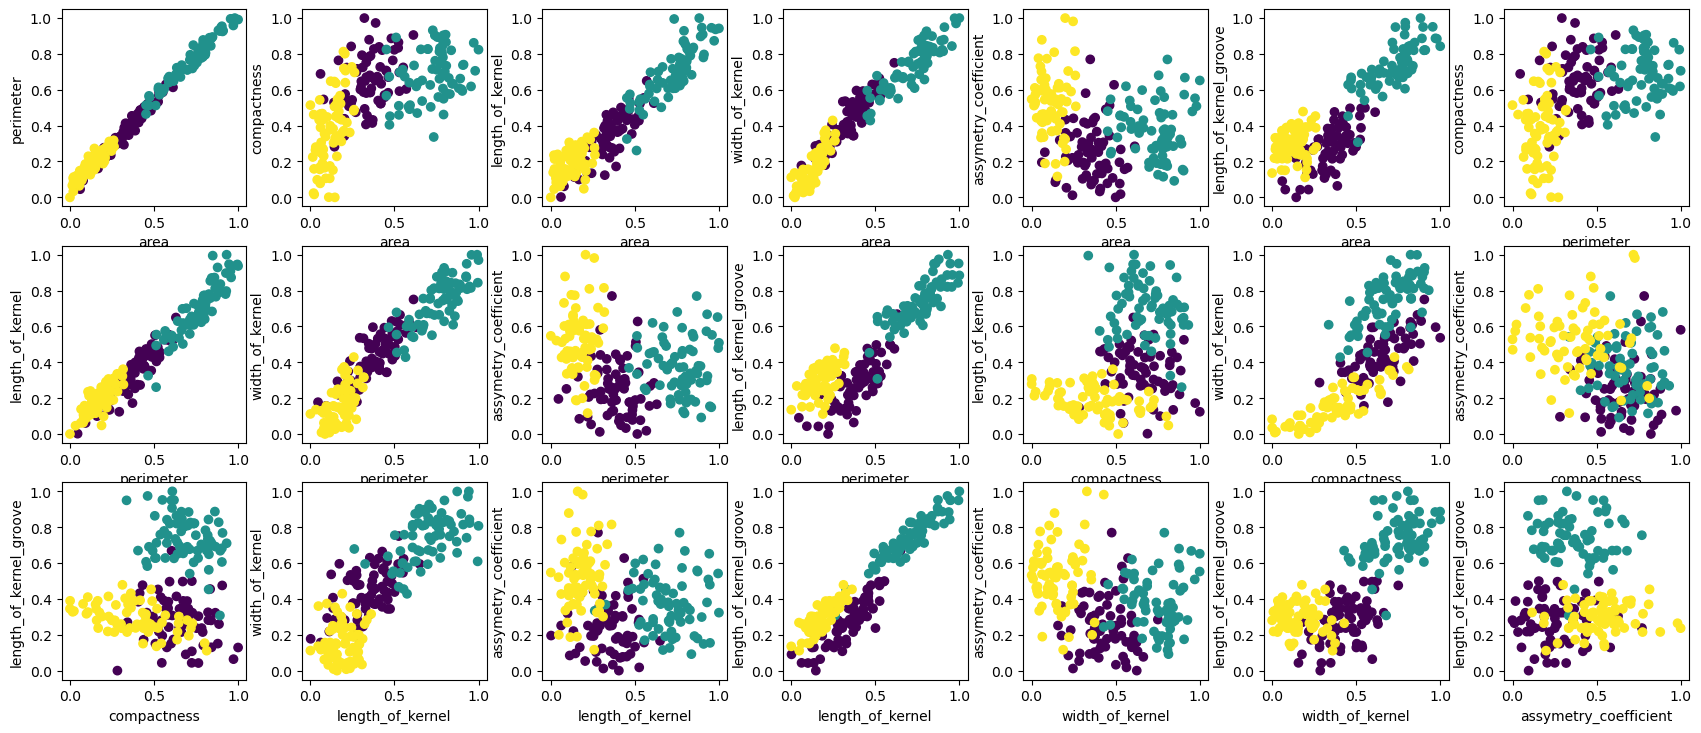

In [18]:
col = X.columns
plt.figure(figsize = (21, 21))
cnt = 0
for i in range(len(col)):
    for j in range(i+1, len(col)):
        cnt += 1
        plt.subplot(len(col), len(col), cnt)
        plt.scatter(X.iloc[:, i], X.iloc[:, j], c = y)
        plt.xlabel(col[i])
        plt.ylabel(col[j])
plt.subplots_adjust(wspace = 0.3)    

From the above maps, the following combinations provide a good clustering for visualization:
*  assymetry_coefficient vs area/perimeter
*  length_of_kernel_groove vs area/perimeter
*  assymetry_coefficient vs length_of_kernel
*  length_of_kernel_groove vs length_of_kernel

We will find the clustering using K-Means and then compare it with the current visualization and also measure the accuracy through other metrics

In [20]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
y_pred = kmeans.fit_predict(X)

C:\Users\HARIbol\anaconda3\envs\PSU_DAAN862\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Finding the centers of the predicted clusters

In [22]:
centers = kmeans.cluster_centers_
centers

array([[0.76100544, 0.79676636, 0.69710195, 0.73317067, 0.77306   ,
        0.3661856 , 0.75913812],
       [0.1233337 , 0.17513685, 0.37817899, 0.18671025, 0.16252742,
        0.49856915, 0.27928792],
       [0.38552543, 0.42246163, 0.66891366, 0.36708494, 0.46959576,
        0.26690579, 0.32281072]])

Plotting the different scatter plots to compare the original scatter plot with the predicted one

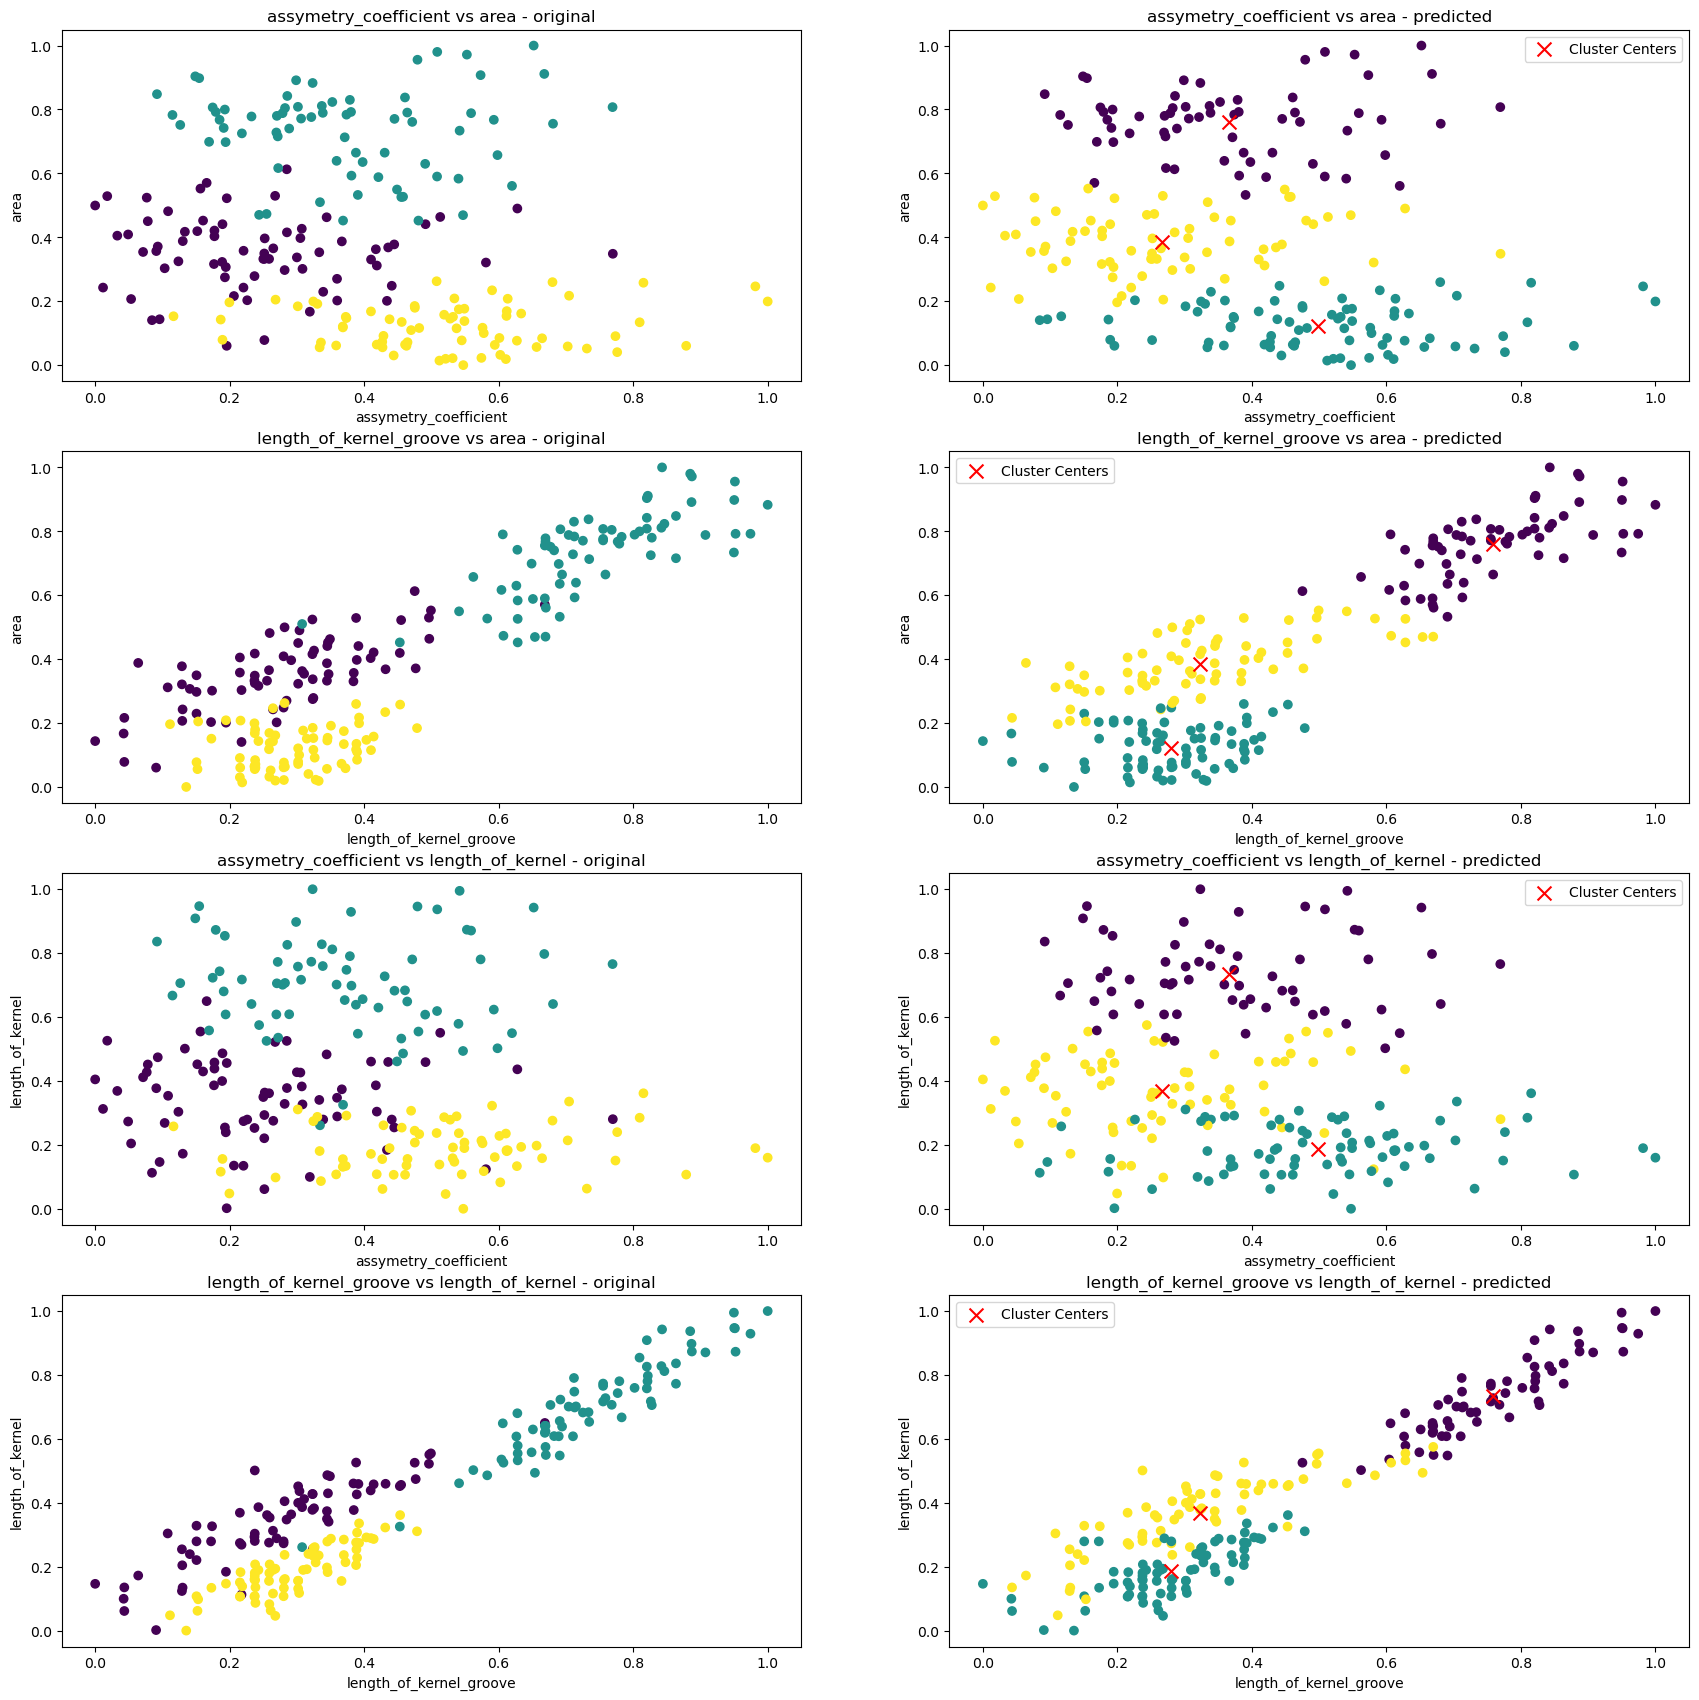

In [24]:
plt.figure(figsize = (21, 21))
plt.subplot(4,2,1)
plt.scatter(X.assymetry_coefficient, X.area, c = y)
plt.title("assymetry_coefficient vs area - original")
plt.xlabel("assymetry_coefficient")
plt.ylabel("area")
plt.subplot(4,2,2)
plt.scatter(X.assymetry_coefficient, X.area, c = y_pred)
plt.scatter(centers[:,5], centers[:,0], s=100, c = 'r', marker = 'x', label = 'Cluster Centers')
plt.title("assymetry_coefficient vs area - predicted")
plt.xlabel("assymetry_coefficient")
plt.ylabel("area")
plt.legend()
plt.subplot(4,2,3)
plt.scatter(X.length_of_kernel_groove, X.area, c = y)
plt.title("length_of_kernel_groove vs area - original")
plt.xlabel("length_of_kernel_groove")
plt.ylabel("area")
plt.subplot(4,2,4)
plt.scatter(X.length_of_kernel_groove, X.area, c = y_pred)
plt.scatter(centers[:,6], centers[:,0], s=100, c = 'r', marker = 'x', label = 'Cluster Centers')
plt.title("length_of_kernel_groove vs area - predicted")
plt.xlabel("length_of_kernel_groove")
plt.ylabel("area")
plt.legend()
plt.subplot(4,2,5)
plt.scatter(X.assymetry_coefficient, X.length_of_kernel, c = y)
plt.title("assymetry_coefficient vs length_of_kernel - original")
plt.xlabel("assymetry_coefficient")
plt.ylabel("length_of_kernel")
plt.subplot(4,2,6)
plt.scatter(X.assymetry_coefficient, X.length_of_kernel, c = y_pred)
plt.title("assymetry_coefficient vs length_of_kernel - predicted")
plt.scatter(centers[:,5], centers[:,3], s=100, c = 'r', marker = 'x', label = 'Cluster Centers')
plt.xlabel("assymetry_coefficient")
plt.ylabel("length_of_kernel")
plt.legend()
plt.subplot(4,2,7)
plt.scatter(X.length_of_kernel_groove, X.length_of_kernel, c = y)
plt.title("length_of_kernel_groove vs length_of_kernel - original")
plt.xlabel("length_of_kernel_groove")
plt.ylabel("length_of_kernel")
plt.subplot(4,2,8)
plt.scatter(X.length_of_kernel_groove, X.length_of_kernel, c = y_pred)
plt.title("length_of_kernel_groove vs length_of_kernel - predicted")
plt.scatter(centers[:,6], centers[:,3], s=100, c = 'r', marker = 'x', label = 'Cluster Centers')
plt.xlabel("length_of_kernel_groove")
plt.ylabel("length_of_kernel")
plt.legend()

##### Observation --> We see that the predicted clusters are almost similar to the original but the predicted wheat type is wrong.

##### Metrics for KMeans

In [27]:
metrics.homogeneity_score(y, y_pred)

0.6644305001480615

In [28]:
metrics.completeness_score(y, y_pred)

0.6664559985348576

In [29]:
metrics.adjusted_rand_score(y, y_pred)

0.6934031600149404

In [30]:
metrics.silhouette_score(X, y_pred, metric = 'euclidean')

0.42212676242010655

### <span style = 'color:red'> 3. Use different linkage type for Hierarchical clustering to the seed data, which linkage type give the best result? </span>

We will put all the different y column variants in a new dataframe so that it is easier to create graphs out of those. We will also store all the metrics in a dataframe to evaluate them easily.

In [33]:
df_y = pd.DataFrame(data = y)
df_y.columns = ["original"]
df_y.head()

,original
0,1
1,1
2,1
3,1
4,1


In [34]:
hier_linkage = ["average","complete","ward"]
hier_metrics = ["homogeneity_score", "completeness_score", "adjusted_rand_score", "silhouette_score"]
hier_cluster = pd.DataFrame(columns = hier_linkage, index = hier_metrics)

In [35]:
for linkage in hier_linkage:
    y_pred = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = linkage).fit_predict(X)
    df_y[linkage] = y_pred # Adding the new predicted y values to the dataframe
    hier_cluster.loc["homogeneity_score", linkage] = metrics.homogeneity_score(y, y_pred)
    hier_cluster.loc["completeness_score", linkage] = metrics.completeness_score(y, y_pred)
    hier_cluster.loc["adjusted_rand_score", linkage] = metrics.adjusted_rand_score(y, y_pred)
    hier_cluster.loc["silhouette_score", linkage] = metrics.silhouette_score(X, y_pred, metric = 'euclidean')

hier_cluster # the metrics dataframe

,average,complete,ward
homogeneity_score,0.701672,0.608817,0.682599
completeness_score,0.709824,0.635687,0.697531
adjusted_rand_score,0.724724,0.566382,0.675209
silhouette_score,0.394375,0.363798,0.381037


##### Conclusion --> 
From the metrics scores, we can say that __"average linkage"__ provides the best result among the three linkage types. We will recheck this using graphs to see which creates a better visualization that is closer to the original.

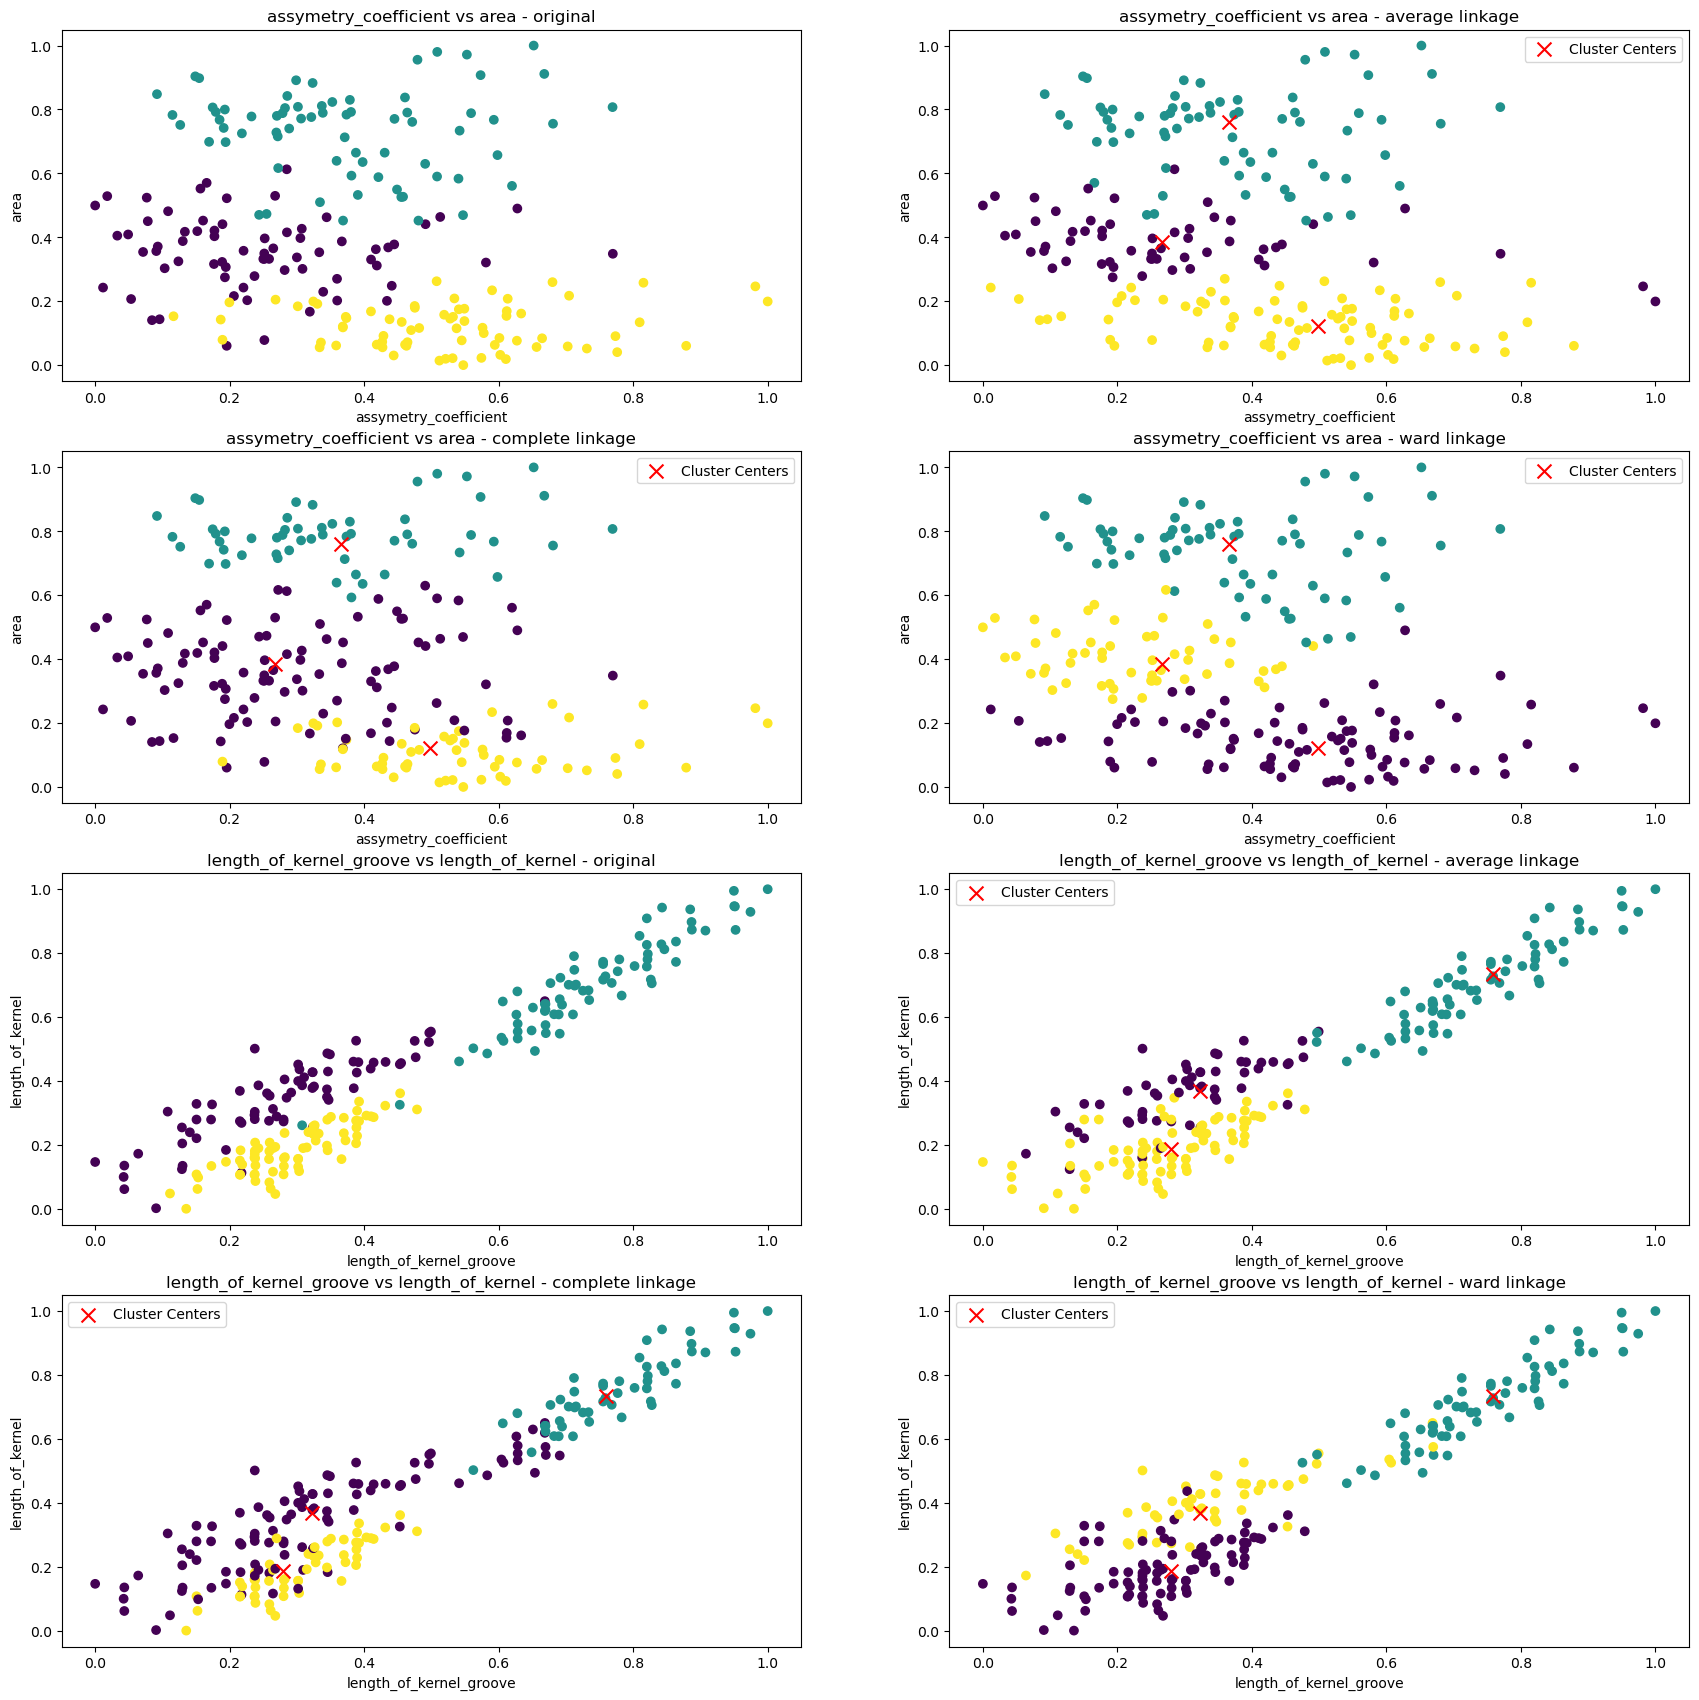

In [37]:
plt.figure(figsize = (21, 21))
plt.subplot(4,2,1)
plt.scatter(X.assymetry_coefficient, X.area, c = df_y.original)
plt.title("assymetry_coefficient vs area - original")
plt.xlabel("assymetry_coefficient")
plt.ylabel("area")
plt.subplot(4,2,2)
plt.scatter(X.assymetry_coefficient, X.area, c = df_y.average)
plt.scatter(centers[:,5], centers[:,0], s=100, c = 'r', marker = 'x', label = 'Cluster Centers')
plt.title("assymetry_coefficient vs area - average linkage")
plt.xlabel("assymetry_coefficient")
plt.ylabel("area")
plt.legend()
plt.subplot(4,2,3)
plt.scatter(X.assymetry_coefficient, X.area, c = df_y.complete)
plt.scatter(centers[:,5], centers[:,0], s=100, c = 'r', marker = 'x', label = 'Cluster Centers')
plt.title("assymetry_coefficient vs area - complete linkage")
plt.xlabel("assymetry_coefficient")
plt.ylabel("area")
plt.legend()
plt.subplot(4,2,4)
plt.scatter(X.assymetry_coefficient, X.area, c = df_y.ward)
plt.scatter(centers[:,5], centers[:,0], s=100, c = 'r', marker = 'x', label = 'Cluster Centers')
plt.title("assymetry_coefficient vs area - ward linkage")
plt.xlabel("assymetry_coefficient")
plt.ylabel("area")
plt.legend()
plt.subplot(4,2,5)
plt.scatter(X.length_of_kernel_groove, X.length_of_kernel, c = df_y.original)
plt.title("length_of_kernel_groove vs length_of_kernel - original")
plt.xlabel("length_of_kernel_groove")
plt.ylabel("length_of_kernel")
plt.subplot(4,2,6)
plt.scatter(X.length_of_kernel_groove, X.length_of_kernel, c = df_y.average)
plt.title("length_of_kernel_groove vs length_of_kernel - average linkage")
plt.scatter(centers[:,6], centers[:,3], s=100, c = 'r', marker = 'x', label = 'Cluster Centers')
plt.xlabel("length_of_kernel_groove")
plt.ylabel("length_of_kernel")
plt.legend()
plt.subplot(4,2,7)
plt.scatter(X.length_of_kernel_groove, X.length_of_kernel, c = df_y.complete)
plt.title("length_of_kernel_groove vs length_of_kernel - complete linkage")
plt.scatter(centers[:,6], centers[:,3], s=100, c = 'r', marker = 'x', label = 'Cluster Centers')
plt.xlabel("length_of_kernel_groove")
plt.ylabel("length_of_kernel")
plt.legend()
plt.subplot(4,2,8)
plt.scatter(X.length_of_kernel_groove, X.length_of_kernel, c = df_y.ward)
plt.title("length_of_kernel_groove vs length_of_kernel - ward linkage")
plt.scatter(centers[:,6], centers[:,3], s=100, c = 'r', marker = 'x', label = 'Cluster Centers')
plt.xlabel("length_of_kernel_groove")
plt.ylabel("length_of_kernel")
plt.legend()

So from the above graphs, we can see that __'average linkage'__ provides the closest result as the original and hence provides the best result among the 3 options.

### <span style= 'color: red'> 4. Use DB-Scan clustering to group the seed data and find the best eps and min_samples value </span>

In [40]:
eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
min_samples =[5, 10, 15, 20, 25, 30]

In [41]:
# Creating a dataframe to store all the combinations of eps and min_samples to find the best option
df_dbs = pd.DataFrame(columns = ["eps", "min_samples", "homogeneity_score", "completeness_score", "adjusted_rand_score", 
                                 "silhouette_score", "clusters"])

In [42]:
for e in eps:
    for sample in min_samples:
        try:
            dbs = DBSCAN(eps = e, min_samples = sample)
            y_pred = dbs.fit_predict(X)
            n_clusters = np.unique(dbs.labels_).size
            homogeneity_score  = metrics.homogeneity_score(y, y_pred)
            completeness_score = metrics.completeness_score(y, y_pred)
            adjusted_rand_score = metrics.adjusted_rand_score(y, y_pred)
            silhouette_score = metrics.silhouette_score(X, y_pred, metric = 'euclidean')
            new_row = pd.DataFrame([{"eps": e, "min_samples": sample,
                                     "homogeneity_score": homogeneity_score, 
                                     "completeness_score": completeness_score, 
                                     "adjusted_rand_score": adjusted_rand_score, 
                                     "silhouette_score": silhouette_score,
                                     "clusters": n_clusters}])
            df_dbs = pd.concat([df_dbs, new_row], axis = 0, ignore_index = True)
        except:
            pass
        
# Faced issues with just running the loops without any exception rule and hence had to build the try-catch block        
df_dbs

C:\Users\HARIbol\AppData\Local\Temp\ipykernel_39916\1873189840.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dbs = pd.concat([df_dbs, new_row], axis = 0, ignore_index = True)


,eps,min_samples,homogeneity_score,completeness_score,adjusted_rand_score,silhouette_score,clusters
0,0.2,5,0.464203,0.459209,0.383863,0.079373,5
1,0.2,10,0.530369,0.452883,0.343268,0.134672,4
2,0.2,15,0.268939,0.316507,0.078813,-0.189610,4
3,0.3,5,0.007114,0.082869,0.000005,0.057476,2
4,0.3,10,0.007114,0.082869,0.000005,0.057476,2
5,0.3,15,0.001538,0.009548,-0.000535,0.200677,2
6,0.3,20,0.004173,0.018719,-0.000013,0.152561,2
7,0.3,25,0.434388,0.541847,0.407449,0.346551,3
8,0.3,30,0.413878,0.474833,0.343605,0.252948,3
9,0.4,15,0.004783,0.173909,0.000000,0.082181,2


We should look at only results which lead to 3 clusters and find the best combination for clusters = 3. 

In [44]:
df_dbs_3 = df_dbs[df_dbs["clusters"] == 3]
df_dbs_3.loc[df_dbs_3["silhouette_score"].idxmax()]

eps                         0.3
min_samples                  25
homogeneity_score      0.434388
completeness_score     0.541847
adjusted_rand_score    0.407449
silhouette_score       0.346551
clusters                      3
Name: 7, dtype: object

The best combination :
__eps = 0.3__ and 
__min_sample = 25__

# End of Assignment